In [1]:
import json
import pickle
import os
import zipfile
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "1"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from glob import glob
from shutil import copyfile

sns.set_style("darkgrid")

In [2]:
#### Settings
### Learning Rate for CNN = 0.01, no learning rate decay

In [3]:
os.chdir("/home/bahy/research/icl-prelab-assignment/")

In [4]:
!pwd

/home/bahy/research/icl-prelab-assignment


In [5]:
datas = []
for file_name in glob("logs_q3/*.txt"):
    print(file_name)
    file = open(file_name, "rb")
    for data in file.readlines():
        if len(data) < 10: # Ignoring blank space/not useful information
            continue
        dict_data = eval(data)
        dict_data['setting'] = file_name.split("/")[1].split("-")[0]
        dict_data['E'] = file_name.split("/")[1].split("-")[2].replace("E", "")
        dict_data['model'] = file_name.split("/")[1].split("-")[-1].split(".")[0]
 
        datas.append(dict_data)
        
datas = pd.DataFrame(datas)

logs_q3/IID-B600-E1-C0.1-MNIST-CNN.txt
logs_q3/NONIID-B10-E1-C0.1-MNIST-CNN.txt
logs_q3/IID-B600-E20-C0.1-MNIST-CNN.txt
logs_q3/NONIID-B50-E1-C0.1-MNIST-CNN.txt
logs_q3/IID-B10-E20-C0.1-MNIST-CNN.txt
logs_q3/IID-B50-E1-C0.1-MNIST-CNN.txt
logs_q3/IID-B50-E20-C0.1-MNIST-CNN.txt
logs_q3/NONIID-B50-E20-C0.1-MNIST-CNN.txt
logs_q3/NONIID-B600-E20-C0.1-MNIST-CNN.txt
logs_q3/NONIID-B600-E1-C0.1-MNIST-CNN.txt
logs_q3/IID-B10-E1-C0.1-MNIST-CNN.txt
logs_q3/NONIID-B10-E20-C0.1-MNIST-CNN.txt


In [6]:
datas.head()

,C,B,comm_round,train_acc,test_acc,train_loss,test_loss,setting,E,model
0,0.1,600,1,0.0985,0.1023,2.2986,2.2978,IID,1,CNN
1,0.1,600,2,0.1060,0.1105,2.2952,2.2944,IID,1,CNN
2,0.1,600,3,0.1142,0.1198,2.2919,2.2911,IID,1,CNN
3,0.1,600,4,0.1220,0.1281,2.2887,2.2877,IID,1,CNN
4,0.1,600,5,0.1294,0.1330,2.2854,2.2844,IID,1,CNN


In [7]:
# Sort the data
ROUNDING_DIGIT = 4

df_metrics = datas.sort_values(by=['setting', 'B', 'E', 'comm_round']).reset_index(drop=True)
df_metrics = df_metrics[['setting', 'B', 'E', 'C', 'comm_round', 'train_acc', 'test_acc', 'train_loss', 'test_loss', 'model']]
df_metrics['train_acc'] = df_metrics['train_acc'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['test_acc'] = df_metrics['test_acc'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['train_loss'] = df_metrics['train_loss'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['test_loss'] = df_metrics['test_loss'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics.head()

,setting,B,E,C,comm_round,train_acc,test_acc,train_loss,test_loss,model
0,IID,10,1,0.1,1,0.6006,0.6148,2.0736,2.0677,CNN
1,IID,10,1,0.1,2,0.7659,0.7795,1.3630,1.3437,CNN
2,IID,10,1,0.1,3,0.8295,0.8434,0.6980,0.6723,CNN
3,IID,10,1,0.1,4,0.8757,0.8815,0.4930,0.4735,CNN
4,IID,10,1,0.1,5,0.8888,0.8976,0.4061,0.3861,CNN


In [8]:
df_metrics.tail()

,setting,B,E,C,comm_round,train_acc,test_acc,train_loss,test_loss,model
11995,NONIID,600,20,0.1,996,0.8641,0.8676,0.3924,0.3817,CNN
11996,NONIID,600,20,0.1,997,0.8988,0.8990,0.2788,0.2746,CNN
11997,NONIID,600,20,0.1,998,0.9220,0.9256,0.2369,0.2273,CNN
11998,NONIID,600,20,0.1,999,0.9468,0.9502,0.1773,0.1652,CNN
11999,NONIID,600,20,0.1,1000,0.9456,0.9477,0.1773,0.1676,CNN


In [9]:
df_metrics.groupby(["model", "setting", "B", "E", "C"]).size()

model  setting  B    E   C  
CNN    IID      10   1   0.1    1000
                     20  0.1    1000
                50   1   0.1    1000
                     20  0.1    1000
                600  1   0.1    1000
                     20  0.1    1000
       NONIID   10   1   0.1    1000
                     20  0.1    1000
                50   1   0.1    1000
                     20  0.1    1000
                600  1   0.1    1000
                     20  0.1    1000
dtype: int64

In [10]:
FIG_SIZE = (12,5)
DASHES = (5, 10)

In [11]:
# Plot function for accuracy
def plot_accuracy(model, setting, B, E):
    current_case = df_metrics[(df_metrics['model'] == model) & (df_metrics['setting'] == setting) & (df_metrics['E'] == E) & (df_metrics['B'] == B)]
    if len(current_case) == 0:
        return "B=%s, E=%s combination does not exists" % (B,E)

    plt.figure(figsize=FIG_SIZE)

    sns.lineplot(data=current_case, x='comm_round', y='train_acc', label='train_accuracy',\
                 dashes=(5, 20))
    sns.lineplot(data=current_case, x='comm_round', y='test_acc', label='test_accuracy',\
                 dashes=(5, 20))
    plt.axhline(y=0.99, color='grey', linestyle='--', label = "99% Accuracy")

    plt.ylim(max(current_case['train_acc'].min(), current_case['test_acc'].min()), None)
    plt.ylabel("Accuracy")
    plt.xlabel("Communication Rounds")
    plt.title("MNIST %s %s\nB=%s, E=%s" % (model, setting, B, E))
    plt.legend(loc='lower right')
    plt.show()

In [12]:
# Plot function for loss
def plot_loss(model, setting, B, E):
    current_case = df_metrics[(df_metrics['model'] == model)\
                              & (df_metrics['setting'] == setting)\
                              & (df_metrics['E'] == E) & (df_metrics['B'] == B)]
    if len(current_case) == 0:
        return "B=%s, E=%s combination does not exists" % (B,E)
    
    plt.figure(figsize=FIG_SIZE)

    sns.lineplot(data=current_case, x='comm_round', y='train_loss', label='train_loss',\
                 dashes=DASHES)
    sns.lineplot(data=current_case, x='comm_round', y='test_loss', label='test_loss',\
                 dashes=DASHES)
    
    plt.ylim(None, min(current_case['train_loss'].max(), current_case['test_loss'].max()))
    plt.ylabel("Loss")
    plt.xlabel("Communication Rounds")
    plt.title("MNIST %s %s\nB=%s, E=%s" % (model, setting, B, E))
    plt.legend(loc='upper right')
    plt.show()

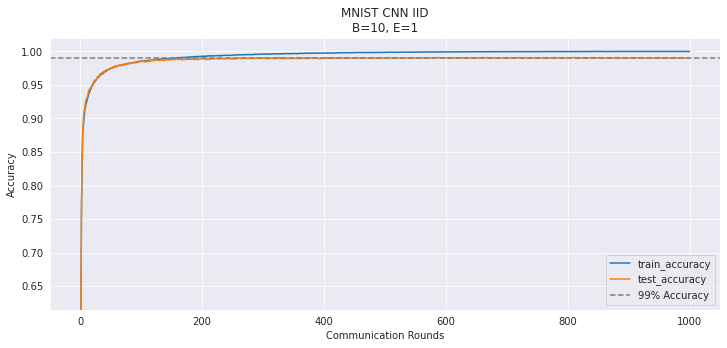

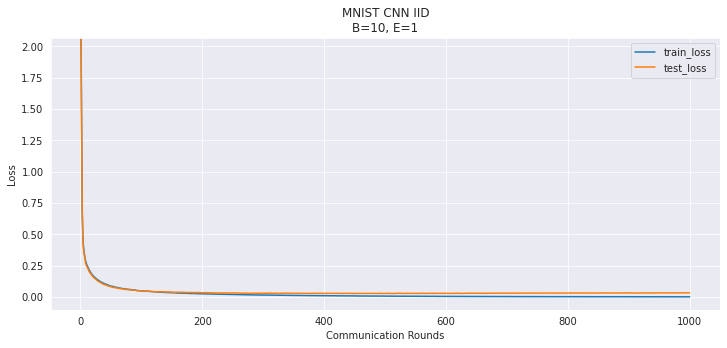

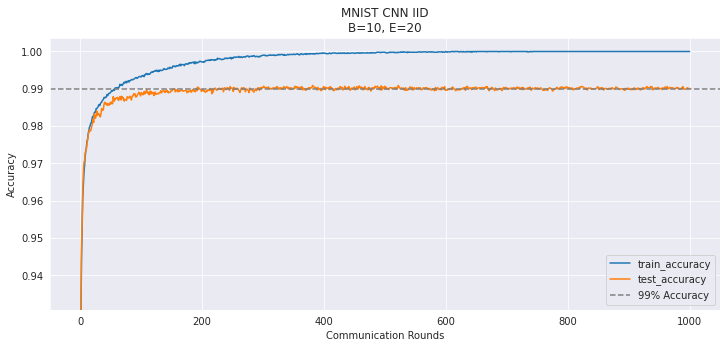

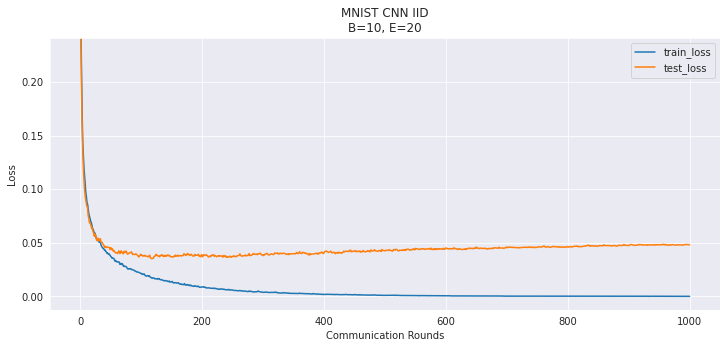

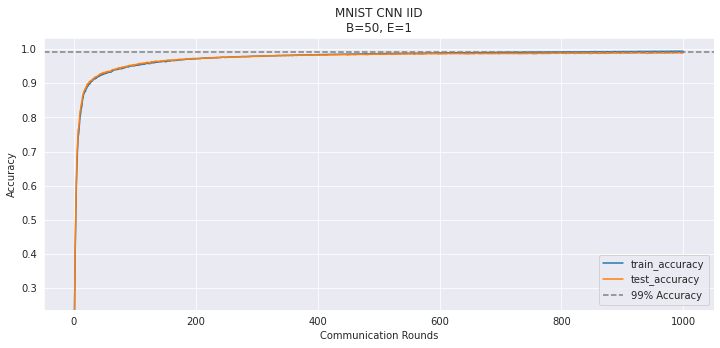

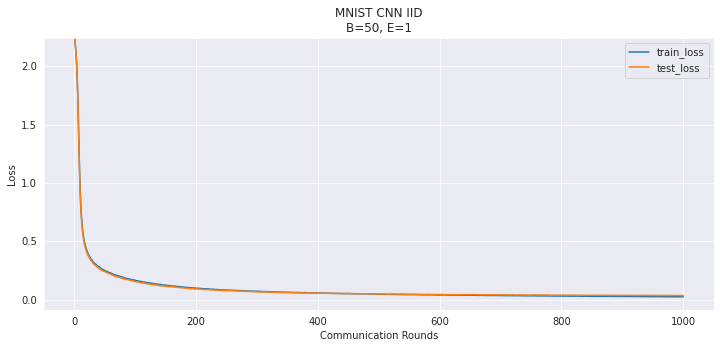

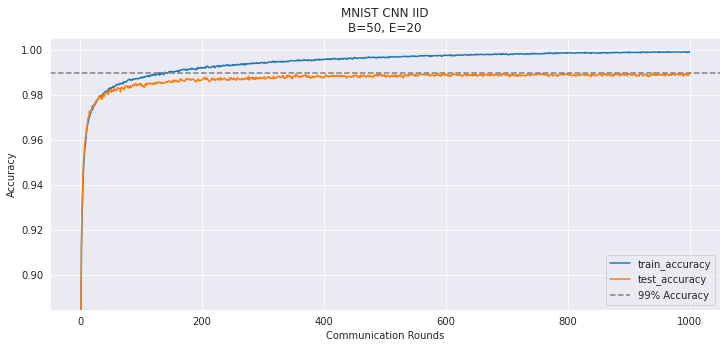

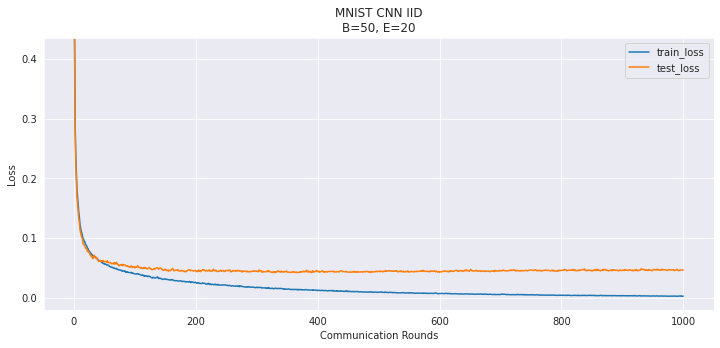

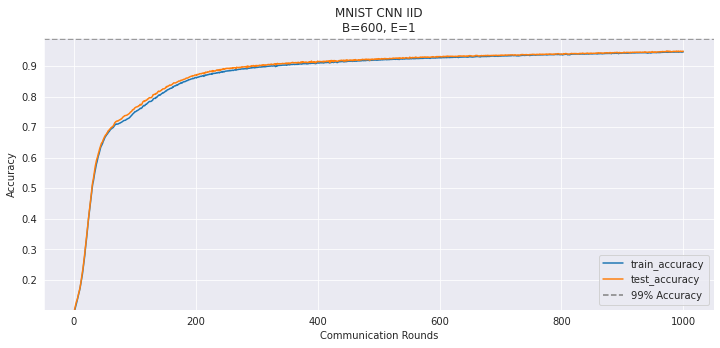

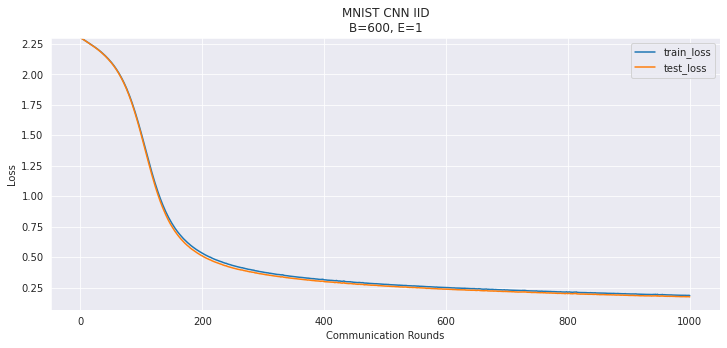

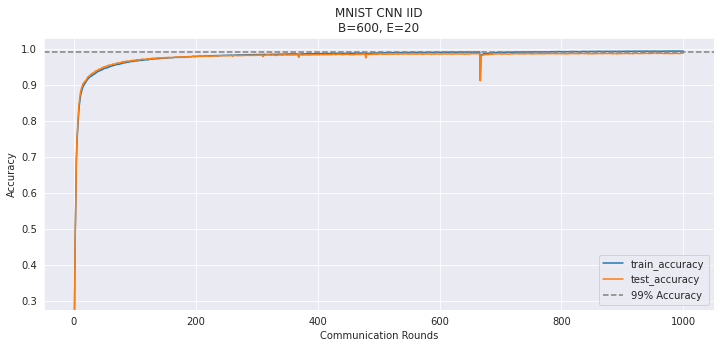

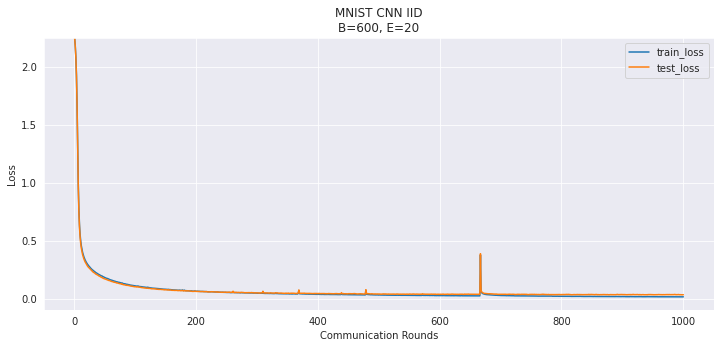

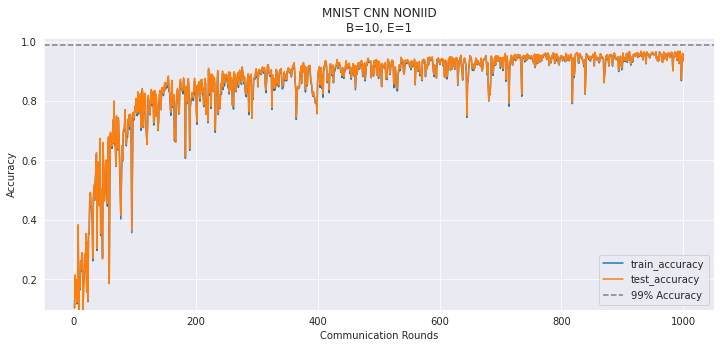

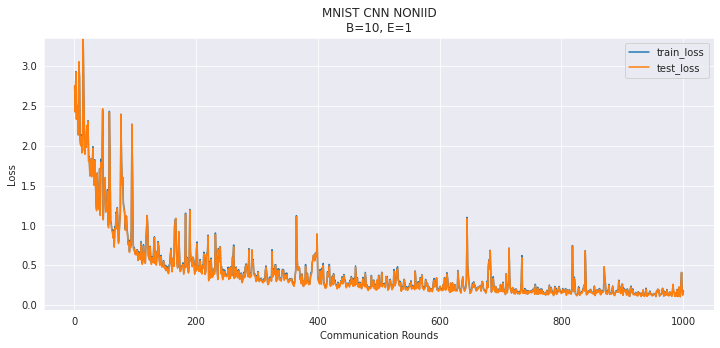

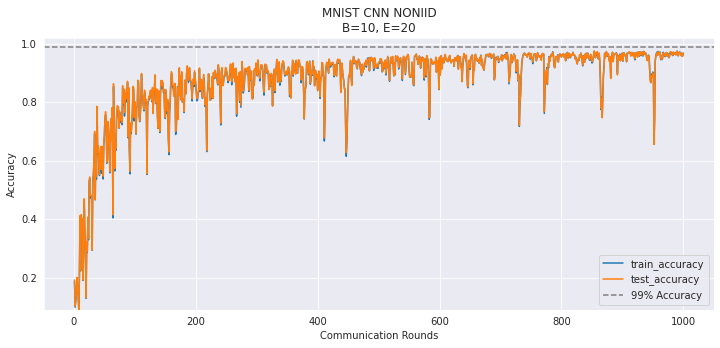

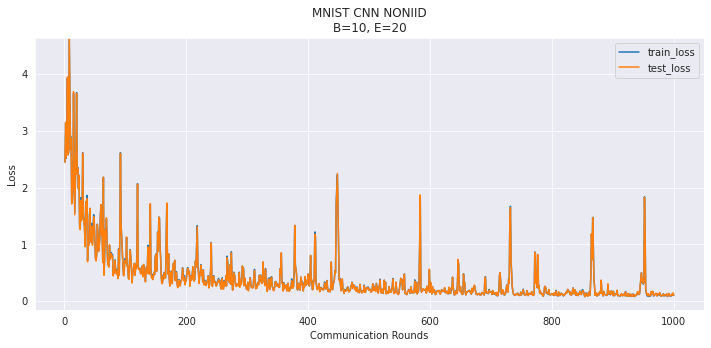

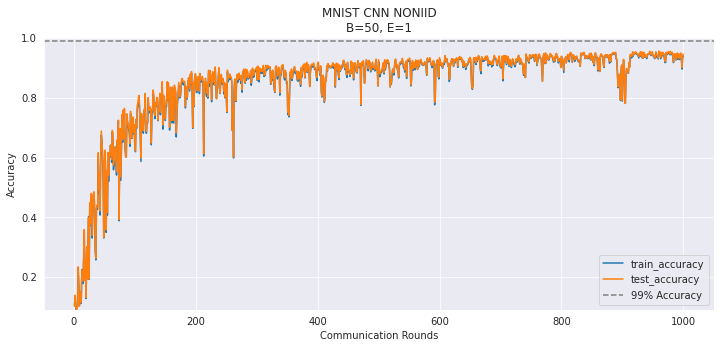

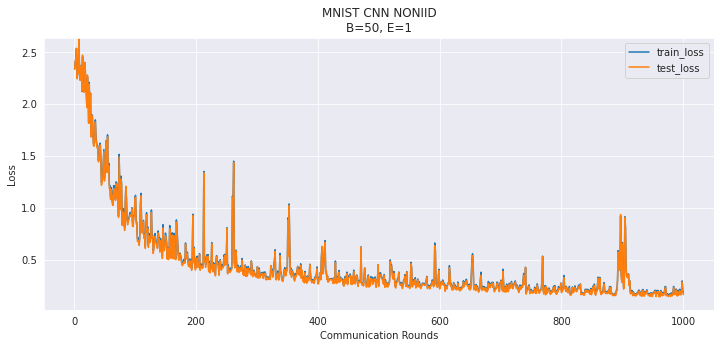

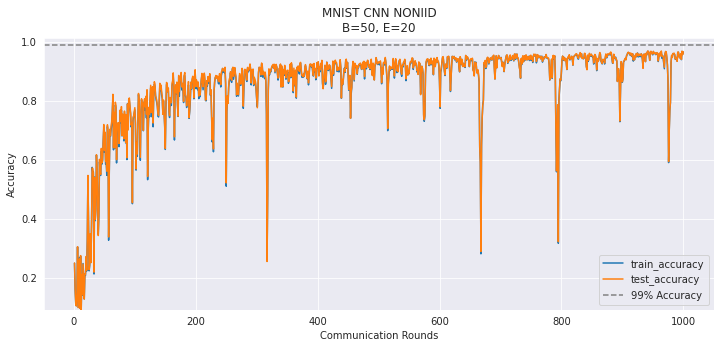

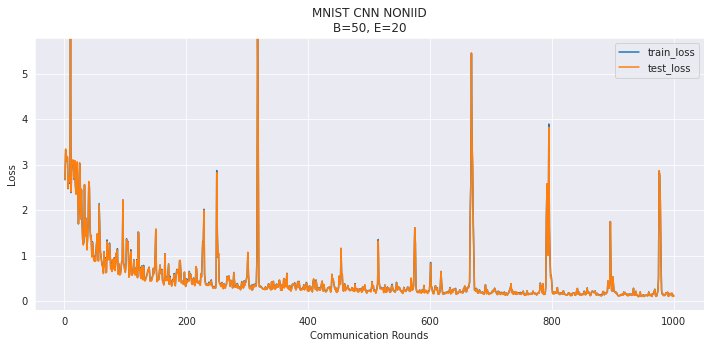

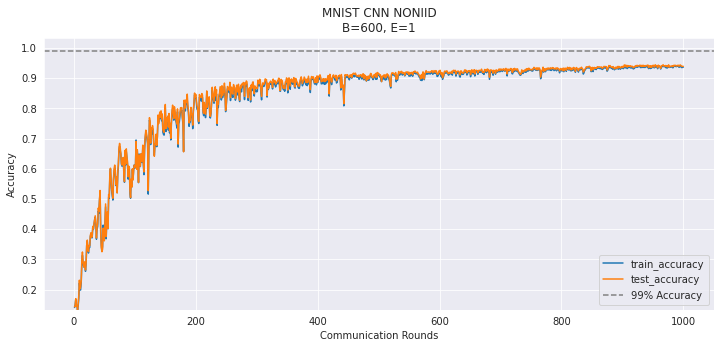

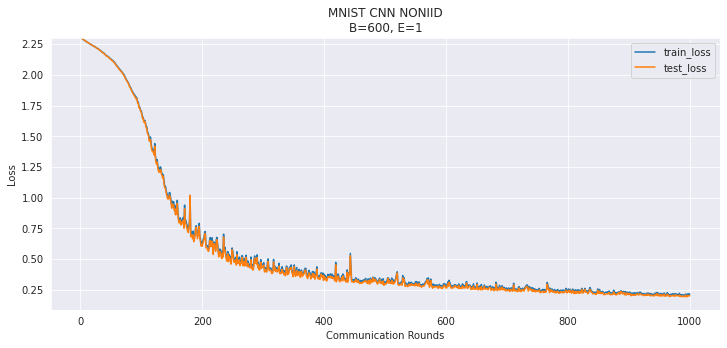

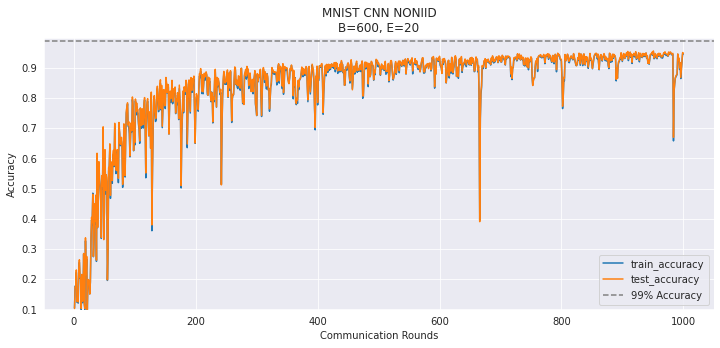

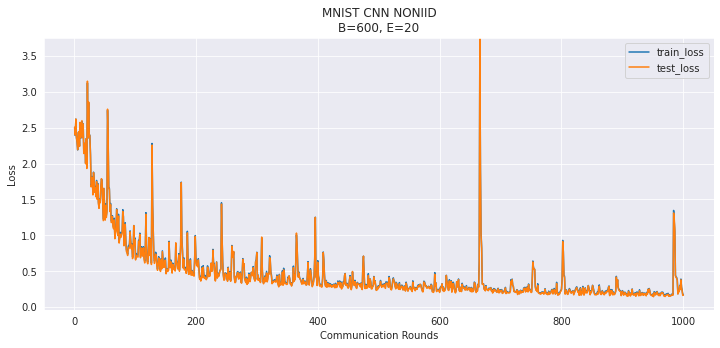

In [13]:
# Plot all accuracy and losses
MODELS = df_metrics['model'].unique()
SETTINGS = df_metrics['setting'].unique()
BATCHES = df_metrics['B'].unique()
EPOCHS = df_metrics['E'].unique()

for model in MODELS:
    for setting in SETTINGS:
        for b in BATCHES:
            for e in EPOCHS:
                plot_accuracy(model, setting, b, e)
                plot_loss(model, setting, b, e)